<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-файла-и-изучение-информации" data-toc-modified-id="Загрузка-файла-и-изучение-информации-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка файла и изучение информации</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-для-обучения-моделей" data-toc-modified-id="Подготовка-данных-для-обучения-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных для обучения моделей</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#SGDRegressor" data-toc-modified-id="SGDRegressor-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>SGDRegressor</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>XGBRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Вам нужно:

Загрузить данные и выполнить их ресемплирование по одному часу.
Проанализировать данные.
Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
Проверить данные на тестовой выборке и сделать выводы.
Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

В данной работе мы посмотрим, какие данные нам предоставлены, оценим их качество, проведем предобработку (если потребуется). Затем проанализируем, как меняется количество заказов по месяцам (по всей выборке), дням и часам. А затем обучим модели регрессии для предсказания количества заказов.

## Подготовка

### Загрузка файла и изучение информации

Загрузим все необходимые библиотеки.

In [1]:
! pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor



from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit


Загрузим файл, но поскольку у нас в данных присутствует временной ряд, чтобы даты загрузились сразу в необходимом формате и преобразовались в индекс добавим два дополнительных параметра: 'index_col' и 'parse_dates'.

In [19]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0]) # загрузка файла

In [20]:
#taxi = pd.read_csv('C:\\Users\\koten\\Downloads\\taxi.csv', index_col = [0], parse_dates = [0]) # чтение файла

In [21]:
display(taxi.head()) # просмотр первых 5 строк

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Далее посмотрим информацию о файле методом info().

In [22]:
taxi.info() #просмотр информации о файле

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В файле один столбец с данными о количестве заказов. Столбец с датой, как и ожидалась, преобразовался в индекс.

Проверим нет ли пропусков в данных.

In [23]:
taxi.isna().sum() #подсчет количества пропущенных значений

num_orders    0
dtype: int64

Пропусков нет. Следующим шагом, проверим что временной ряд расположен в хронологическом порядке. Если это так, то при вызове метода 'is_monotonic', мы получим True.

In [24]:
print(taxi.index.is_monotonic)

True


Порядок соблюден.

Поскольку нам не нужно знать поминутно, сколько делается заказов, мы проведем ресемплирование, таким образом сгруппировав данные за час. И посчитаем сумму заказов за час.

In [25]:
taxi_selection = taxi.resample('1H').sum() #ресемплирование с подсчетом суммы заказов за час
display(taxi_selection.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

Мы загрузили данные, произведя сразу при загрузке преобразование столбца с датами в формат Datetime и переведение его в индекс. Проверили, что в данных нет пропусков. Хронологический порядок соблюден. И в завершение провели ресемплирование с глубиной интервала один час.

## Анализ

В этой части проекта мы посмотрим, как меняется количество заказов в течении всего периода, за месяц, неделю и в течении дня.

Сначала в общем посмотрим как меняется количесто заказов в среднем по месяцам за период представленный в выборке.

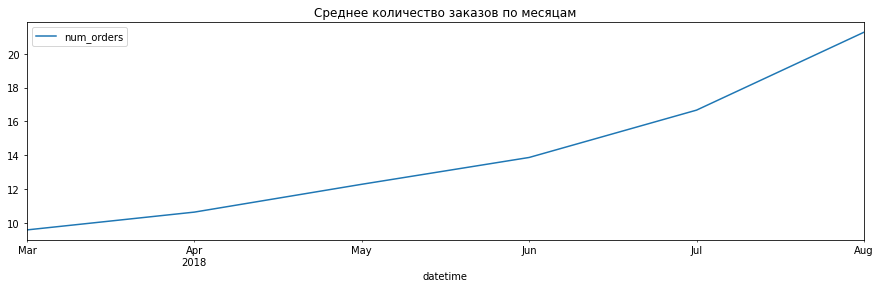

In [26]:
taxi.resample('1M').mean().plot(figsize = (15,4), legend=True)
plt.title("Среднее количество заказов по месяцам")
plt.show()

Среднее количество заказов растет из месяца в месяц.

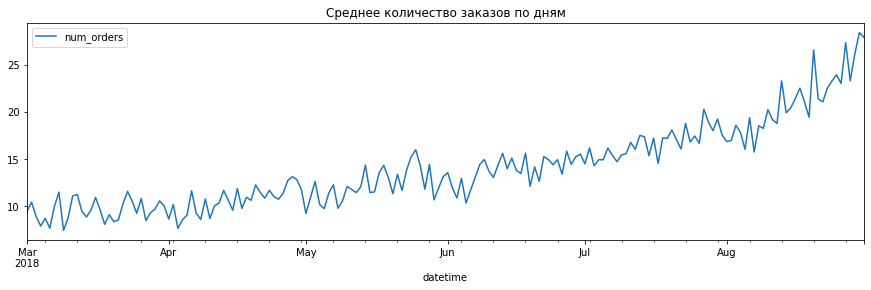

In [27]:
taxi.resample('1D').mean().plot(figsize = (15,4), legend=True)
plt.title('Среднее количество заказов по дням')
plt.show()

Разбив по дням, мы по прежнему видим тенденцию к росту, но внутри отдельных месяцев есть подъемы и спады. С середины июня до августа спады и падения меньше, чем в другие месяца. Сильнее всего скачки в августе.

Посмотрим теперь график, где интервал час.

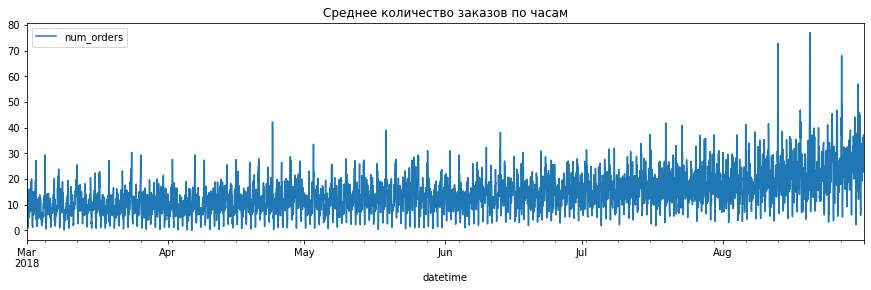

In [28]:
taxi.resample('1H').mean().plot(figsize = (15,4), legend=True)
plt.title('Среднее количество заказов по часам')
plt.show()

Посмотрим на тренд и сезонность данных с помощью функции seasonal_decompose(). Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток. Причем сезонность посмотрим на срезе данных за последние две недели августа.


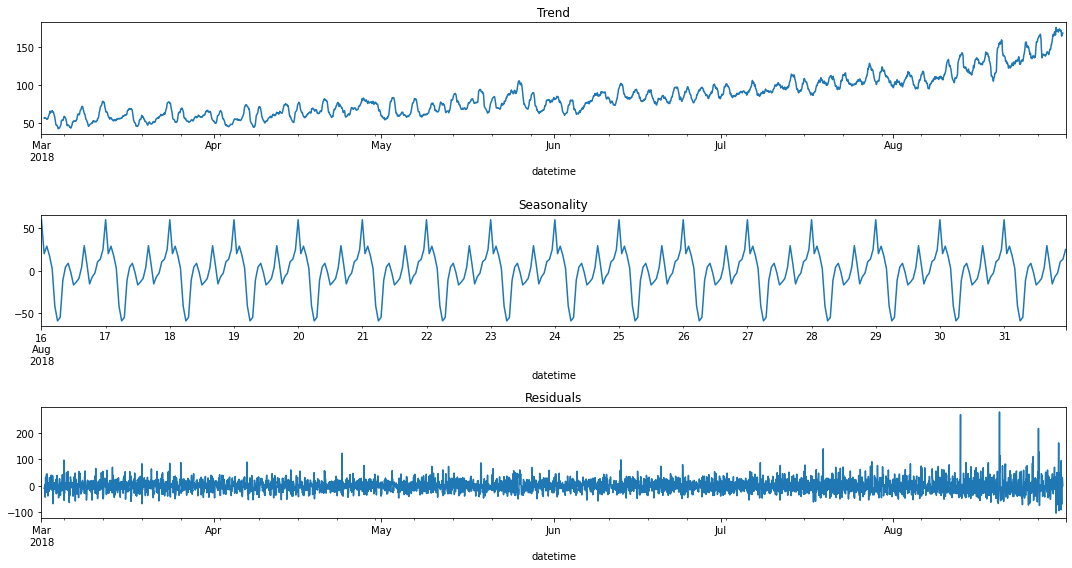

In [29]:
decomposed =  seasonal_decompose(taxi_selection) 

plt.figure(figsize=(15, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca()) # тренд
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal['2018-08-16':'2018-08-31'].plot(ax=plt.gca())# сезонность
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) # остатки
plt.title('Residuals')
plt.tight_layout()

Как уже было сказано ранее в данных наблюдается тренд к увеличению заказов. А вот сезонность мы посмотрим еще на более узком интервале, чтобы понять в какие часы наибольший спад, а в какоий подъем. На данном этапе характер изменения количества заказов по дням очень похож.

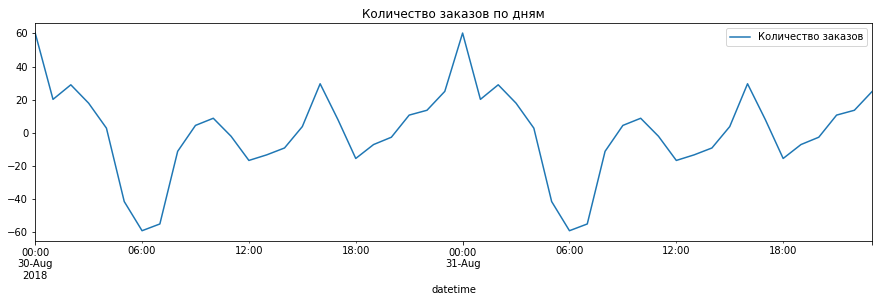

In [30]:
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(label = 'Количество заказов', figsize = (15,4), legend=True)
plt.title('Количество заказов по дням')
plt.show()

Итак, мы видим, что минимум заказов в 6 утра, а максимум в 12 ночи. Мы видим что данные не стационарны, а занчит сложно предсказуемы. Построим график с количеством заказов по дням и добавим к нему скользящие среднее и стандартное отклонение.

**Вывод**

В данном разделе мы посмотрели как меняется количество заказов во времени. Среднее количество заказов на протяжении всего периода растет. При анализе по дням, мы видим, что минимум заказов в шесть утра, а максимум в двенадцать ночи. Обнаружили что, данные представляют собой нестационарный временной ряд - среднее меняется со временем. Прогнозировать такие ряды сложнее:  их свойства меняются слишком быстро. 

## Обучение

### Подготовка данных для обучения моделей

В этом разделе мы обучим несколько моделей для предсказания количества заказов. Но сначала напишем функцию, которая из имеющихся данных создаст нам признаки по которым мы будем обучать модели. В качестве метрики качества будем использовать RMSE.

Создадим признаки для горизонта прогнозирования в один шаг. Напишем функцию для создания признаков.

In [31]:
def make_features(data, max_lag, rolling_mean_size):
    
  #  data['difference'] = data['num_orders'] - data['num_orders'].shift(fill_value=0)
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
   
make_features(taxi_selection, 24, 48)

Разделим нашу выборку на 3 части: обучающую, валидационную и тестовую. В данном, конкретном случае тестовая и валидайионная выборка будут по 10%, а обучающая 80% от общего объема данных.

Для того, чтобы даные не перемешивались в функции train_test_split() укажем аргумент shuffle=False.

In [32]:
train, valid_test = train_test_split(taxi_selection, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
train = train.dropna()

Проверим правильность разделения. Убедимся что данные не перемешались и каждая из подвыборок идет последовательно друг за другом по времени.

In [33]:
train.shape, valid.shape, test.shape

((3484, 28), (442, 28), (442, 28))

In [34]:
print(train.index.is_monotonic)
print(valid.index.is_monotonic)
print(test.index.is_monotonic)


True
True
True


In [35]:
display(train.tail(2))
display(valid.head(2))
display(valid.tail(2))
display(test.head(2))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-26 02:00:00,197,3,2,73.0,149.0,138.0,84.0,110.0,111.0,137.0,...,95.0,122.0,66.0,60.0,65.0,69.0,124.0,142.0,145.0,100.9375
2018-07-26 03:00:00,141,3,3,197.0,73.0,149.0,138.0,84.0,110.0,111.0,...,93.0,95.0,122.0,66.0,60.0,65.0,69.0,124.0,142.0,102.9375


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-26 04:00:00,131,3,4,141.0,197.0,73.0,149.0,138.0,84.0,110.0,...,83.0,93.0,95.0,122.0,66.0,60.0,65.0,69.0,124.0,102.8750
2018-07-26 05:00:00,83,3,5,131.0,141.0,197.0,73.0,149.0,138.0,84.0,...,99.0,83.0,93.0,95.0,122.0,66.0,60.0,65.0,69.0,103.4375


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 12:00:00,92,0,12,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,121.416667
2018-08-13 13:00:00,119,0,13,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,122.020833


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,...,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,123.395833
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,124.000000


Разделение прошло успешно. Далее разделим данные на признаки и целевой признак.

In [36]:
features_train = train.drop(['num_orders'], axis=1) #признаки
features_valid = valid.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders'] # целевой признак
target_valid = valid['num_orders']
target_test = test['num_orders']

Чтобы при масштабировании не учитывать временные показатели, создадим список столбцов по которым будем масштабировать данные.

In [37]:
list_columns = list(features_train.columns)
print(list_columns)

del list_columns[3:5]
print(list_columns)

['dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean']
['dayofweek', 'hour', 'lag_1', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean']


In [38]:
pd.options.mode.chained_assignment = None

numeric = list_columns
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

В качестве метрики качества будем использовать RMSE. напишем функцию для ее расчета.

In [39]:
def rmse(target, predicted):
    
    return mean_squared_error(target, predicted)**0.5

rmse_score = make_scorer(rmse, greater_is_better = False)

Данные готовы.

### Линейная регрессия

In [40]:
%%time
model_lr = LinearRegression() 
model_lr.fit(features_train, target_train) 
predicted_valid = model_lr.predict(features_valid)
rmse_lr = rmse(target_valid, predicted_valid)
print('Линейная регрессия:')
print('RMSE: {:.20f}'.format(rmse_lr))

Линейная регрессия:
RMSE: 34.26160725839712029028
CPU times: user 62.7 ms, sys: 51.3 ms, total: 114 ms
Wall time: 92.1 ms


Результат полученный на линейной регрессии практически идеальный (RMSE: 0.00000000000020022904). Проверим, так же ли хорошо все будет на тестовой выборке.

### Дерево решений

In [41]:
%%time

clf_dtr = DecisionTreeRegressor(random_state=12345)
parametrs = {'max_depth': range (1,10, 1),
            }
tscv = TimeSeriesSplit()
grid_dtr = GridSearchCV(clf_dtr, parametrs, cv = tscv, scoring = rmse_score)
grid_dtr.fit(features_train, target_train)
print(grid_dtr.best_params_)
print()

predicted_valid = grid_dtr.predict(features_valid)
print('Дерево решений (с подбором гиперпараметров):')
rmse_dtr = rmse(target_valid, predicted_valid)
print('RMSE: {:.2f}'.format(rmse_dtr))


{'max_depth': 4}

Дерево решений (с подбором гиперпараметров):
RMSE: 41.27
CPU times: user 754 ms, sys: 6.25 ms, total: 761 ms
Wall time: 758 ms


Дерево решений дает тоже неплохой результат. RMSE: 17.35 и время расчета очень маленькое.

### Случайный лес

In [42]:
%%time

clf_rfg = RandomForestRegressor(random_state=12345)
parametrs = {'n_estimators': range (30, 101),
              'max_depth': range (1,16),
            }
tscv = TimeSeriesSplit()
grid_rfg  = RandomizedSearchCV(clf_rfg , parametrs, cv = tscv, n_iter = 10, scoring = rmse_score)
grid_rfg.fit(features_train, target_train)
print(grid_rfg.best_params_)

predicted_valid = grid_rfg.predict(features_valid)
rmse_rfg  = rmse(target_valid, predicted_valid)
print('Случайный лес:')
print('RMSE: {:.2f}'.format(rmse_rfg))

{'n_estimators': 90, 'max_depth': 14}
Случайный лес:
RMSE: 32.26
CPU times: user 37 s, sys: 101 ms, total: 37.1 s
Wall time: 37.1 s


Случайный лес с подбором гиперпараметров с помощью RandomizedSearchCV дал результат RMSE: 14.37 на валидационной выборке. Чтобы не происходило перемешивания признаков, воспользуемся TimeSeriesSplit(). Возможно с помощью GridSearchCV можно было бы получить еще лучше результат, но время обучения было бы гораздо больше.

Далее обучим более сложные модели. В большенстве из них мы посмотрим результат на стандартных гиперпараметрах и дополнительно подберем гиперпараметры с помощью GridSearchCV. 

### CatBoostRegressor

In [43]:
%%time

model_c = CatBoostRegressor(random_state=12345, loss_function='RMSE')


model_c.fit(features_train, target_train, verbose=50)



predicted_valid = model_c.predict(features_valid)
rmse_c  = rmse(target_valid, predicted_valid)
print('CatBoost:')
print('RMSE: {:.2f}'.format(rmse_c))


Learning rate set to 0.049869
0:	learn: 35.0106126	total: 53.5ms	remaining: 53.4s
50:	learn: 22.1239023	total: 292ms	remaining: 5.44s
100:	learn: 20.1816021	total: 549ms	remaining: 4.89s
150:	learn: 19.0242528	total: 838ms	remaining: 4.71s
200:	learn: 18.1001463	total: 1.1s	remaining: 4.37s
250:	learn: 17.2618368	total: 1.33s	remaining: 3.97s
300:	learn: 16.4979893	total: 1.59s	remaining: 3.7s
350:	learn: 15.8313880	total: 1.84s	remaining: 3.4s
400:	learn: 15.1744351	total: 2.08s	remaining: 3.11s
450:	learn: 14.5636340	total: 2.33s	remaining: 2.83s
500:	learn: 14.0662192	total: 2.58s	remaining: 2.57s
550:	learn: 13.6025878	total: 2.83s	remaining: 2.3s
600:	learn: 13.1095665	total: 3.06s	remaining: 2.03s
650:	learn: 12.6880697	total: 3.32s	remaining: 1.78s
700:	learn: 12.2932638	total: 3.58s	remaining: 1.53s
750:	learn: 11.8925342	total: 3.86s	remaining: 1.28s
800:	learn: 11.4514634	total: 4.12s	remaining: 1.02s
850:	learn: 11.0871357	total: 4.37s	remaining: 765ms
900:	learn: 10.7287120

Без подбора гиперпараметров RMSE на валидационной выборке равно 12.92. Время обучения небольшое.

In [44]:
%%time

model_cat = CatBoostRegressor(random_state=12345, loss_function='RMSE')
parametrs = {'depth': range (5, 16, 3),
            'iterations': range (50, 201, 30)
            }
tscv = TimeSeriesSplit()
grid_cat = GridSearchCV(model_cat, parametrs, cv = tscv)
grid_cat.fit(features_train, target_train, verbose=100)
print(grid_cat.best_params_)


predicted_valid = grid_cat.predict(features_valid)
rmse_cat  = rmse(target_valid, predicted_valid)
print('CatBoost:')
print('RMSE: {:.2f}'.format(rmse_cat))


Learning rate set to 0.429546
0:	learn: 25.0620989	total: 3.19ms	remaining: 156ms
49:	learn: 6.8498362	total: 94.5ms	remaining: 0us
Learning rate set to 0.479002
0:	learn: 24.6089919	total: 2.57ms	remaining: 126ms
49:	learn: 10.1734601	total: 107ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.0145953	total: 2.83ms	remaining: 139ms
49:	learn: 12.1824030	total: 138ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.9806345	total: 3.27ms	remaining: 160ms
49:	learn: 13.1951152	total: 132ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 27.5943678	total: 3.09ms	remaining: 152ms
49:	learn: 14.8415541	total: 140ms	remaining: 0us
Learning rate set to 0.29313
0:	learn: 26.4408557	total: 2.17ms	remaining: 171ms
79:	learn: 6.2924140	total: 156ms	remaining: 0us
Learning rate set to 0.32688
0:	learn: 25.9626550	total: 2.83ms	remaining: 223ms
79:	learn: 9.3233732	total: 201ms	remaining: 0us
Learning rate set to 0.348443
0:	learn: 27.3728565	total: 2.85ms	remaining: 225ms
79:	learn: 11

KeyboardInterrupt: 

Из указанного диапазона лучшее сочетание гиперпараметров - это {'depth': 5, 'iterations': 200}. При этих значениях RMSE равно 11.67 на валидационной выборке. Время обучения уже достаточно значительное (примерно 50 минут на локальном компьютере).

### LGBMRegressor

In [30]:
%%time

       
model_l = LGBMRegressor(random_state=12345)           
model_l.fit(features_train, target_train)

predicted_valid = model_l.predict(features_valid)
rmse_l  = rmse(target_valid, predicted_valid)
print('LGBMRegressor:')
print('RMSE: {:.2f}'.format(rmse_l))

LGBMRegressor:
RMSE: 13.08
Wall time: 128 ms


LGBMRegressor на стандартных гиперпараметрах показывает результат RMSE равный 13.08. Время обучения небольшое.

In [31]:
%%time

est_list = []
depth_list = []
for est in range(200, 501, 100):
    est_list.append(est) 
for depth in range(5, 16, 3):
        depth_list.append(depth)
     
    
params = {'max_depth': depth_list, 
          'n_estimators': est_list 
              }
model_lgbm = LGBMRegressor(random_state=12345)
tscv = TimeSeriesSplit()            
grid_lgbm = GridSearchCV(model_lgbm, params, cv = tscv, scoring = rmse_score)
grid_lgbm.fit(features_train, target_train)

print(grid_lgbm.best_params_)
print()



predicted_valid = grid_lgbm.predict(features_valid)
rmse_lgbm  = rmse(target_valid, predicted_valid)
print('LGBMRegressor:')
print('RMSE: {:.2f}'.format(rmse_lgbm))


{'max_depth': 5, 'n_estimators': 200}

LGBMRegressor:
RMSE: 12.61
Wall time: 16.2 s


Из указанного диапазона лучшее сочетание гиперпараметров - это {'max_depth': 5, 'n_estimators': 200}. При этих значениях RMSE равно 12.61 на валидационной выборке. Время обучения примерно 17 минут (на локальном компьютере).

### SGDRegressor

In [32]:
%%time

model_sdg = SGDRegressor(random_state=12345, shuffle=False)
model_sdg.fit(features_train, target_train)
predicted_valid = model_sdg.predict(features_valid)
rmse_SGD  = rmse(target_valid, predicted_valid)
print('SGDRegressor:')
print('RMSE: {:.2f}'.format(rmse_SGD))


SGDRegressor:
RMSE: 0.12
Wall time: 39.6 ms


Даже без подбора гиперпараметров SGDRegressor дает прекрассный результат - RMSE равно 0.12. Время обучения около 40 секунд

### XGBRegressor

In [33]:
%%time

 

model_x = XGBRegressor(random_state=12345)
model_x.fit(features_train, target_train)
          
predicted_valid = model_x.predict(features_valid)
rmse_x  = rmse(target_valid, predicted_valid)
print('XGBRegressor:')
print('RMSE: {:.2f}'.format(rmse_x))


XGBRegressor:
RMSE: 11.84
Wall time: 304 ms


Показатель RMSE на моделе без подбора гиперпараметров близок с RMSE модели CatBoost с подбором гиперпараметров и равен 11.84. Время обучение небольшое.

In [34]:
%%time
   
    
params = {'max_depth': range (5, 16, 5), 
          'n_estimators': range (300, 551, 20)
         }

model_xgb = XGBRegressor(random_state=12345)
tscv = TimeSeriesSplit()
grid_xgb = GridSearchCV(model_xgb, params, cv = tscv, scoring = rmse_score)
grid_xgb.fit(features_train, target_train)
print(grid_xgb.best_params_)
print()          
          

predicted_valid = grid_xgb.predict(features_valid)
rmse_xgb  = rmse(target_valid, predicted_valid)
print('XGBRegressor:')
print('RMSE: {:.2f}'.format(rmse_xgb))


{'max_depth': 5, 'n_estimators': 500}

XGBRegressor:
RMSE: 12.01
Wall time: 2min 1s


К сожалению, найти лучшее сочетание, чем гиперпараметры по умолчанию, для этой модели не удалось. При 'max_depth': 5 и 'n_estimators': 500, RMSE равно 12.01

Далее сведем полученные результаты в одну таблицу.

In [35]:
score_data = {'RSME': [rmse_lr, rmse_dtr, rmse_rfg, rmse_c,
                       rmse_cat, rmse_l, rmse_lgbm, rmse_SGD, rmse_x, rmse_xgb]
                          }
score_df = pd.DataFrame(score_data, index = ['Линейная регрессия',
                                             'Дерево решений c подбором гиперпараметров', 
                                             'Случайный лес c подбором гиперпараметров','CatBoostRegressor',
                                             'CatBoostRegressor с подбором гиперпараметров', 'LGBMRegressor',
                                             'LGBMRegressor с подбором гиперпараметров',
                                             'SGDRegressor', 'XGBRegressor', 'XGBRegressor с подбором гиперпараметров'])
score_df['RSME'] = round(score_df['RSME'],3)
print('Результаты RMSE  моделей и время их работы')
display(score_df)

Результаты RMSE  моделей и время их работы


,RSME
Линейная регрессия,0.000
Дерево решений c подбором гиперпараметров,17.345
Случайный лес c подбором гиперпараметров,14.365
CatBoostRegressor,12.917
CatBoostRegressor с подбором гиперпараметров,11.666
LGBMRegressor,13.080
LGBMRegressor с подбором гиперпараметров,12.612
SGDRegressor,0.120
XGBRegressor,11.840
XGBRegressor с подбором гиперпараметров,12.012


**Вывод**

В этом разделе мы обучили несколько моделей. Для некоторых мы подбирали гиперпараметры с помощью GridSearchCV и RandomizedSearchCV. Лучше всего показали себя линейная регрессия и SGDRegressor (RMSE около нуля на линейной регрессии и 0.12 на SGDRegressor). Все остальные модели также показали хорошие результаты на валидационной выборке.

## Тестирование

Все наши модели показали достаточно хороший результат, поэтому их все проверим на тестовой выборке.

**Линейная регрессия**

In [45]:
predicted_lr_test = model_lr.predict(features_test)
rmse_lr_test = rmse(target_test, predicted_lr_test)
print('Линейная регрессия:')
print('RMSE: {:.20f}'.format(rmse_lr_test))


Линейная регрессия:
RMSE: 45.49542628037720959355


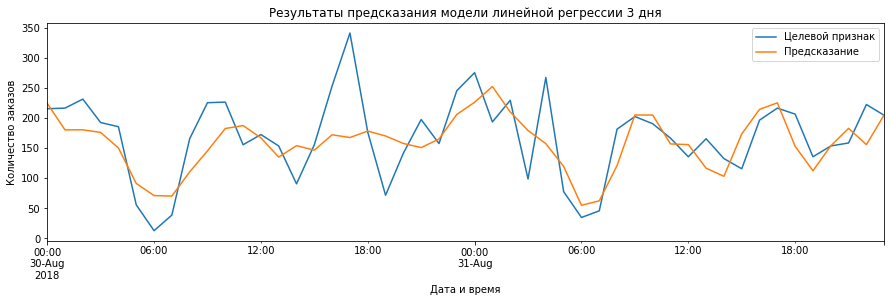

In [46]:
correct_prediction_lr = pd.DataFrame({ 
    'target_test_lr' : target_test,
    'predicted_lr_test' : predicted_lr_test 
    })
correct_prediction_lr['2018-08-30':'2018-08-31'].plot(figsize = (15,4), label = 'заказы такси', legend=True)

plt.title('Результаты предсказания модели линейной регрессии 3 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend (('Целевой признак', 'Предсказание'))
plt.show()

Поскольку ошибка у нас близка к нулю, то и графики слились в одну линию.

**Дерево решений (с подбором гиперпараметров)**

In [47]:
predicted_dtr_test = grid_dtr.predict(features_test)
rmse_dtr_test = rmse(target_test, predicted_dtr_test)
print('Дерево решений (с подбором гиперпараметров):')
print('RMSE: {:.2f}'.format(rmse_dtr_test))


Дерево решений (с подбором гиперпараметров):
RMSE: 65.70


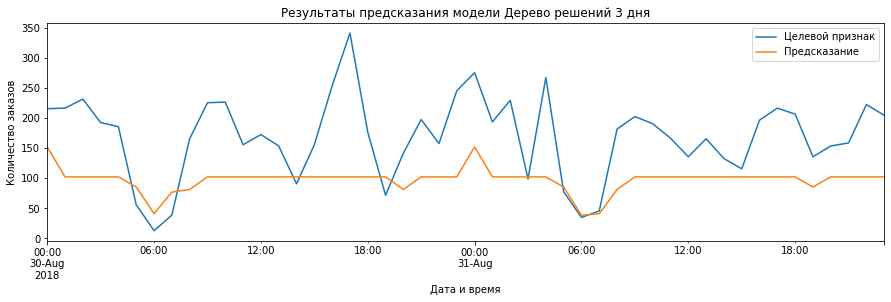

In [48]:
correct_prediction_dtr = pd.DataFrame({ 
    'target_test_dtr' : target_test,
    'predicted_dtr_test' : predicted_dtr_test 
    })
correct_prediction_dtr['2018-08-30':'2018-08-31'].plot(figsize = (15,4), label = 'заказы такси', legend=True)

plt.title('Результаты предсказания модели Дерево решений 3 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend (('Целевой признак', 'Предсказание'))
plt.show()

**Случайный лес (с подбором гиперпараметров)**

In [49]:
predicted_rfg_test = grid_rfg.predict(features_test)
rmse_rfg_test  = rmse(target_test, predicted_rfg_test)
print('Случайный лес с подбором гиперпараметров:')
print('RMSE: {:.2f}'.format(rmse_rfg_test))

Случайный лес с подбором гиперпараметров:
RMSE: 50.34


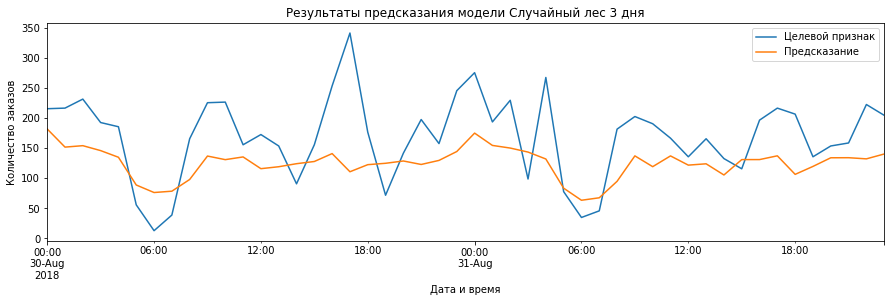

In [50]:
correct_prediction_rfg = pd.DataFrame({ 
    'target_test_rfg' : target_test,
    'predicted_rfg_test' : predicted_rfg_test 
    })
correct_prediction_rfg['2018-08-30':'2018-08-31'].plot(figsize = (15,4), label = 'заказы такси', legend=True)

plt.title('Результаты предсказания модели Случайный лес 3 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend (('Целевой признак', 'Предсказание'))
plt.show()

**CatBoost**

In [51]:
predicted_test = model_c.predict(features_test)
rmse_c_test  = rmse(target_test, predicted_test)
print('CatBoost:')
print('RMSE: {:.2f}'.format(rmse_c_test))

CatBoost:
RMSE: 53.15


**CatBoost с подбором гиперпараметров**

In [ ]:
predicted_cat_test = grid_cat.predict(features_test)
rmse_cat_test = rmse(target_test, predicted_cat_test)
print('CatBoost с подбором гиперпараметров:')
print('RMSE: {:.2f}'.format(rmse_cat_test))


In [ ]:
correct_prediction_cat = pd.DataFrame({ 
    'target_test_cat' : target_test,
    'predicted_cat_test' : predicted_cat_test 
    })
correct_prediction_cat['2018-08-30':'2018-08-31'].plot(figsize = (15,4), label = 'заказы такси', legend=True)

plt.title('Результаты предсказания модели CatBoost с подбором гиперпараметров 3 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend (('Целевой признак', 'Предсказание'))
plt.show()

**LGBMRegressor**

In [ ]:
predicted_test = model_l.predict(features_test)
rmse_l_test  = rmse(target_test, predicted_test)
print('LGBMRegressor:')
print('RMSE: {:.2f}'.format(rmse_l_test))

**LGBMRegressor с подбором гиперпараметров**

In [46]:
predicted_lgbm_test = grid_lgbm.predict(features_test)
rmse_lgbm_test  = rmse(target_test, predicted_lgbm_test)
print('LGBMRegressor с подбором гиперпараметров:')
print('RMSE: {:.2f}'.format(rmse_lgbm_test))

LGBMRegressor с подбором гиперпараметров:
RMSE: 24.17


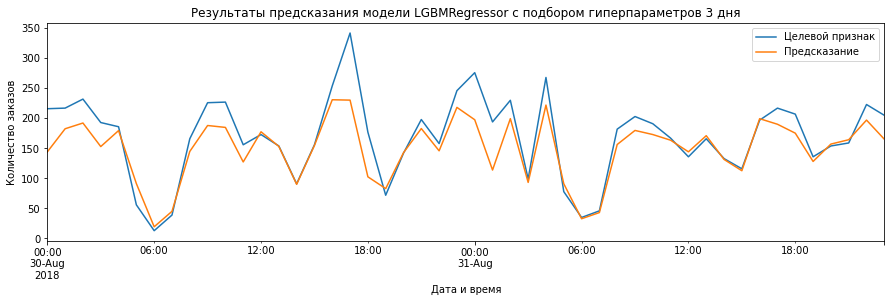

In [47]:
correct_prediction_lgbm = pd.DataFrame({ 
    'target_test_lgbm' : target_test,
    'predicted_lgbm_test' : predicted_lgbm_test 
    })
correct_prediction_lgbm['2018-08-30':'2018-08-31'].plot(figsize = (15,4), label = 'заказы такси', legend=True)

plt.title('Результаты предсказания модели LGBMRegressor с подбором гиперпараметров 3 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend (('Целевой признак', 'Предсказание'))
plt.show()

**SGDRegressor**

In [48]:
predicted_sdg_test = model_sdg.predict(features_test)
rmse_SGD_test  = rmse(target_test, predicted_sdg_test)
print('SGDRegressor:')
print('RMSE: {:.2f}'.format(rmse_SGD_test))

SGDRegressor:
RMSE: 0.17


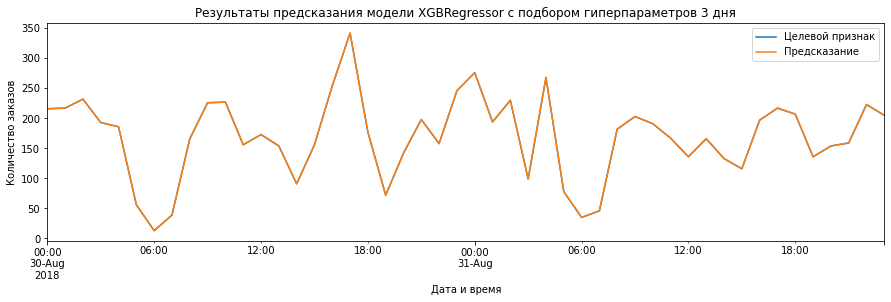

In [49]:
correct_prediction_sdg = pd.DataFrame({ 
    'target_test_sdg' : target_test,
    'predicted_sdg_test' : predicted_sdg_test 
    })
correct_prediction_sdg['2018-08-30':'2018-08-31'].plot(figsize = (15,4), label = 'заказы такси', legend=True)

plt.title('Результаты предсказания модели SGDRegressor 3 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend (('Целевой признак', 'Предсказание'))
plt.show()

И опять, как и в линейной регрессии, посколько ошибка очень мала линиии целевого признака и предсказания слились в одну.

**XGBRegressor**

In [50]:
predicted_test = model_x.predict(features_test)
rmse_x_test  = rmse(target_test, predicted_test)
print('XGBRegressor:')
print('RMSE: {:.2f}'.format(rmse_x_test))

XGBRegressor:
RMSE: 24.40


**XGBRegressor с подбором гиперпараметров**

In [51]:
predicted_xgb_test = grid_xgb.predict(features_test)
rmse_xgb_test  = rmse(target_test, predicted_xgb_test)
print('XGBRegressor с подбором гиперпараметров:')
print('RMSE: {:.2f}'.format(rmse_xgb_test))

XGBRegressor с подбором гиперпараметров:
RMSE: 23.60


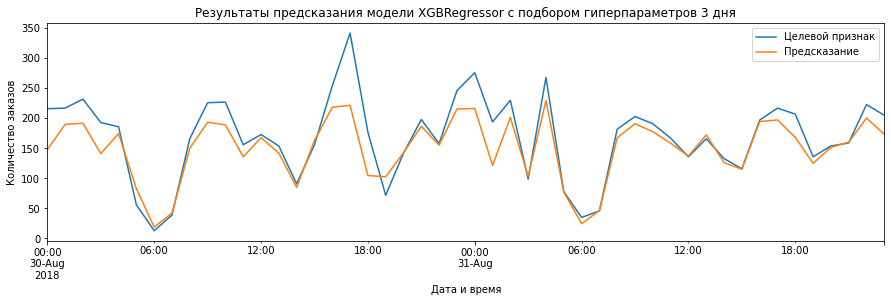

In [52]:
correct_prediction_xgb = pd.DataFrame({ 
    'target_test_xgb' : target_test,
    'predicted_xgb_test' : predicted_xgb_test 
    })
correct_prediction_xgb['2018-08-30':'2018-08-31'].plot(figsize = (15,4), label = 'заказы такси', legend=True)

plt.title('Результаты предсказания модели XGBRegressor с подбором гиперпараметров 3 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend (('Целевой признак', 'Предсказание'))
plt.show()

И опять сведем все результаты в одну таблицу, чтобы было нагляднее.

In [54]:
score_data = {'RMSE': [rmse_lr, rmse_dtr, rmse_rfg, rmse_c,
                       rmse_cat, rmse_l, rmse_lgbm, rmse_SGD, rmse_x, rmse_xgb],
                       'RSME_test': [rmse_lr_test, rmse_dtr_test, rmse_rfg_test, rmse_c_test,
                       rmse_cat_test, rmse_l_test, rmse_lgbm_test, rmse_SGD_test, rmse_x_test, rmse_xgb_test]   }
score_df = pd.DataFrame(score_data, index = ['Линейная регрессия',
                                             'Дерево решений c подбором гиперпараметров', 
                                             'Случайный лес c подбором гиперпараметров','CatBoostRegressor',
                                             'CatBoostRegressor с подбором гиперпараметров', 'LGBMRegressor',
                                             'LGBMRegressor с подбором гиперпараметров',
                                             'SGDRegressor','XGBRegressor', 'XGBRegressor с подбором гиперпараметров'])
score_df['RMSE'] = round(score_df['RSME'],3)
score_df['RMSE_test'] = round(score_df['RMSE_test'],3)
print('Результаты RMSE  моделей и время их работы')
display(score_df)

Результаты RMSE  моделей и время их работы


,RSME,RSME_test
Линейная регрессия,0.000,0.000
Дерево решений c подбором гиперпараметров,17.345,30.799
Случайный лес c подбором гиперпараметров,14.365,28.500
CatBoostRegressor,12.917,24.273
CatBoostRegressor с подбором гиперпараметров,11.666,21.715
LGBMRegressor,13.080,25.078
LGBMRegressor с подбором гиперпараметров,12.612,24.173
SGDRegressor,0.120,0.169
XGBRegressor,11.840,24.396
XGBRegressor с подбором гиперпараметров,12.012,23.601


Лидером по качеству предсказания у нас является линейная регрессия RMSE около 0.000000000000241304231. На втором месте SGDRegressor с показателем корня из среднеквадратичной ошибки равным 0.17. Стоит отметить, что RSME на тестовой выборке значительно больше, чем на валидационной, хотя и не превышает показателя RMSE 48, указанного в задании как верхняя граница.

На всех графиках сравнения целевых признаков и предсказаний, кроме линейной регрессии и SGD, линия предсказания более сграденная, она не достигает реальных пиков. И тут нужно посчитать уже насколько критичен будет показатель упущенной выгоды и сравнить его с затратами, которые будет нести предприятие, ориентируясь на более высокие показатели заказов, в случае если реально заказов окажется меньше.

## Общий вывод

В данном проекте мы строили прогнозы на основании данных, содержащих времянной ряд. Нашей задачей было предсказать количество заказов такси и при этом, чтобы величина RMSE не превышала 48 на тестовой выборке.

В первом разделе работы мы загрузили и изучили данные. Проверили, что нет пропусков в данных и времянной ряд находится в хронологическом порядке. Учитывая, что нам нужны показатели за час, а не поминутно, мы провели ресемплирование данных с интервалом в один час. 

Во втором разделе мы изучили характер поведения данных - как меняются средние значения количества заказов такси на протяжении всего периода указазанного в выборке. Мы обнаружили что среднее количество заказов на протяжении всего периода растет. При анализе по дням, мы видим, что минимум заказов в шесть утра, а максимум в двенадцать ночи. Обнаружили что, данные представляют собой нестационарный временной ряд - среднее меняется со временем. 

В третьем разделе мы создали признаки для обучения модели. Далее провели масштабироание признаков, поскольку многие из использованных моделей чувствительны к диапазону разброса значений.

Затем мы обучили следующие модели:
- Линейная регрессия
- Дерево решений c подбором гиперпараметров 
- Случайный лес c подбором гиперпараметров
- CatBoostRegressor и CatBoostRegressor с подбором гиперпараметров
- LGBMRegressor и LGBMRegressor с подбором гиперпараметров
- SGDRegressor
- XGBRegressor и XGBRegressor с подбором гиперпараметров

Лучшие результаты получен на линейной регрессии и SGDRegressor (RMSE около нуля на линейной регрессии и 0.12 на SGDRegressor). Все остальные модели также показали хорошие результаты на валидационной выборке.

В четвертом разделе мы проверили наши обученные модели на тестовой выборке. Лучше всего предсказывает линейная регрессия (RMSE около 0.000000000000241304231). На втором месте SGDRegressor с показателем корня из среднеквадратичной ошибки равным 0,17. Худший результат у дерева решений.